## Introduction

### Objective
Develop a machine learning model to predict a stock's closing price 5 trading days into the future using historical data from March 17, 1980, to December 27, 2024. The solution should demonstrate predictive accuracy and practical trading value.

### Data Loading
The dataset is loaded from `/kaggle/input/stockprice/question4-stock-data.csv`, containing columns: `Date`, `Adj Close`, `Close`, `High`, `Low`, `Open`, and `Volume`. The initial step lists available files and previews the data structure.

In [ ]:
# Install required libraries
!pip install numpy pandas matplotlib seaborn scikit-learn statsmodels tensorflow xgboost

In [1]:
# Import essential libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')


# List files in the directory
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/stockprice/question4-stock-data.csv


In [2]:
df = pd.read_csv('/kaggle/input/stockprice/question4-stock-data.csv')
df.tail()

,Unnamed: 0,Date,Adj Close,Close,High,Low,Open,Volume
11286,11286,2024-12-20,178.169998,178.169998,179.919998,175.839996,175.839996,425700.0
11287,11287,2024-12-23,180.449997,180.449997,180.619995,177.970001,179.119995,422700.0
11288,11288,2024-12-24,181.429993,181.429993,181.720001,180.830002,181.000000,168600.0
11289,11289,2024-12-26,197.360001,197.360001,198.000000,193.130005,195.970001,1281200.0
11290,11290,2024-12-27,199.520004,199.520004,201.000000,198.179993,200.360001,779500.0


## Data Overview

### Initial Exploration
- **Dataset**: Contains 11,291 entries from March 17, 1980, to December 27, 2024.
- **Columns**: `Adj Close`, `Close`, `High`, `Low`, `Open`, `Volume` (after dropping `Unnamed: 0`).
- **Observations**: The tail shows recent data (e.g., Dec 27, 2024: Close $199.52), but we’ll check for sorting or duplication issues.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11291 entries, 0 to 11290
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  11291 non-null  int64  
 1   Date        11181 non-null  object 
 2   Adj Close   11198 non-null  float64
 3   Close       11174 non-null  float64
 4   High        11196 non-null  float64
 5   Low         11164 non-null  float64
 6   Open        11188 non-null  float64
 7   Volume      11146 non-null  float64
dtypes: float64(6), int64(1), object(1)
memory usage: 705.8+ KB


### Data Types and Missing Values
- **Data Types**: `Date` is initially an object; numerical columns are float64.
- **Missing Values**: Approximately 93-145 missing values per column (e.g., 110 in `Date`, 145 in `Volume`). These will be handled after preprocessing.

### Missing Values Handling


In [4]:
print("Missing Values:\n", df.isnull().sum())

Missing Values:
 Unnamed: 0      0
Date          110
Adj Close      93
Close         117
High           95
Low           127
Open          103
Volume        145
dtype: int64


check for missing indexes(Dates)

In [5]:
missing_dates = df[df['Date'].isna()]
missing_dates

,Unnamed: 0,Date,Adj Close,Close,High,Low,Open,Volume
103,103,NaN,2.617510,3.750795,3.792939,3.750795,0.000000,38262.0
152,152,NaN,3.195910,4.579622,4.607718,4.579622,0.000000,8898.0
196,196,NaN,2.784167,3.989610,4.003658,3.989610,0.000000,4449.0
283,283,NaN,3.921361,5.619169,5.661312,5.619169,0.000000,20466.0
286,286,NaN,3.882148,5.562977,5.605121,5.562977,0.000000,14237.0
...,...,...,...,...,...,...,...,...
10128,10128,NaN,116.889999,116.889999,117.349998,116.110001,116.199997,179100.0
10587,10587,NaN,158.270004,158.270004,161.619995,158.169998,160.740005,355800.0
10772,10772,NaN,143.190002,143.190002,144.800003,142.649994,144.759995,223400.0
11256,11256,NaN,178.449997,178.449997,179.679993,177.259995,179.000000,638000.0


- 110 rows lack Date, which breaks time series continuity. Dropping them ensures every row is timestamped.


In [6]:
print("Missing Dates in Index:", df.index.isnull().sum())
df = df[df['Date'].notnull()]
print("Shape after dropping missing Date rows:", df.shape)
print("Missing Values in columns after dropping Date:\n", df.isnull().sum())

Missing Dates in Index: 0
Shape after dropping missing Date rows: (11181, 8)
Missing Values in columns after dropping Date:
 Unnamed: 0      0
Date            0
Adj Close      93
Close         116
High           95
Low           126
Open          100
Volume        145
dtype: int64


- **Method**: Forward fill followed by backward fill to maintain time-series continuity.


In [7]:

price_cols = ['Close', 'Adj Close', 'High', 'Low', 'Open']
df[price_cols] = df[price_cols].fillna(method='ffill')
# Interpolate Volume
df['Volume'] = df['Volume'].interpolate(method='linear')
# Handle any remaining NaN (e.g., at start)
df.fillna(method='bfill', inplace=True)  # Back-fill if needed
print("Missing Values after filling:\n", df.isnull().sum())

Missing Values after filling:
 Unnamed: 0    0
Date          0
Adj Close     0
Close         0
High          0
Low           0
Open          0
Volume        0
dtype: int64


- **Result**: All missing values are resolved.

In [8]:
df.head()

,Unnamed: 0,Date,Adj Close,Close,High,Low,Open,Volume
0,0,1980-03-17,2.296798,3.291227,3.344743,3.291227,0.000000,41109.0
1,1,1980-03-18,2.306134,3.304606,3.358122,3.304606,0.000000,9343.0
2,2,1980-03-19,2.306134,3.304606,3.304606,3.304606,3.304606,0.0
3,3,1980-03-20,2.306134,3.304606,3.358122,3.304606,0.000000,10277.0
4,4,1980-03-21,2.362154,3.384880,3.438396,3.384880,0.000000,8409.0


In [9]:
(df['Volume']==0).sum()

130

zero values are detected in volume

In [10]:
# Descriptive statistics
df.describe()

,Unnamed: 0,Adj Close,Close,High,Low,Open,Volume
count,11181.000000,11181.000000,11181.000000,11181.000000,11181.000000,11181.000000,1.118100e+04
mean,5649.054557,63.668077,72.126528,72.548109,71.712502,68.018510,2.150102e+05
std,3261.893889,52.350679,51.362731,51.620587,51.043881,55.922053,3.880049e+05
min,0.000000,2.259452,3.237711,3.237711,3.237711,0.000000,0.000000e+00
25%,2824.000000,19.224636,27.548208,27.735613,27.548208,0.000000,1.353100e+04
50%,5646.000000,50.615738,66.062500,66.660004,65.470001,66.000000,9.110000e+04
75%,8475.000000,104.843605,114.400002,114.980003,113.680000,114.500000,2.926500e+05
max,11290.000000,254.770004,254.770004,255.229996,253.589996,255.000000,1.858270e+07



### Descriptive Statistics
- **Range**: Close prices range from $3.24 (1980) to $254.77 (recent peak), with a mean of $72.03.
  
- **Volatility**: High standard deviation ($51.32) indicates significant fluctuations.
- **Volume**: Mean volume is 214,416 shares, with a max of 18.58M, suggesting high trading activity periods.
- **Anomaly**: `Open` has a minimum of 0, which is invalid and requires correction.

## Data Preprocessing

In [11]:
# Preprocess the data
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values('Date')
df = df.drop(df.columns[0], axis=1)
df.set_index('Date', inplace=True)



Date column coverted to datetime data type for future analytics.
index row is dropped because of redundancy.
turn Date into index.

In [12]:
# Fix invalid Open values (replace 0 with previous Close)
df['Open'] = df['Open'].replace(0, pd.NA)  # Replace 0 with NaN first
df['Open'] = df['Open'].fillna(df['Close'].shift(1)).ffill()  # Fill with previous Close, then forward fill
#print("Fixed Open Column Preview:\n", df[['Open', 'Close']].head())


the first open entry is not inserted.so we have to handle it.we can add the same value as close for that

In [13]:
df['Open'].iloc[0] = df['Close'].iloc[0] if pd.isna(df['Open'].iloc[0]) else df['Open'].iloc[0]


In [14]:
df.head()

,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
1980-03-17,2.296798,3.291227,3.344743,3.291227,3.291227,41109.0
1980-03-18,2.306134,3.304606,3.358122,3.304606,3.291227,9343.0
1980-03-19,2.306134,3.304606,3.304606,3.304606,3.304606,0.0
1980-03-20,2.306134,3.304606,3.358122,3.304606,3.304606,10277.0
1980-03-21,2.362154,3.384880,3.438396,3.384880,3.304606,8409.0


## Exploratory Data Analysis (EDA)

### Objective
Identify trends, seasonality, anomalies, and patterns to inform feature engineering.

### Data Preprocessing
- Converted `Date` to datetime and sorted chronologically.
- Dropped the redundant `Unnamed: 0` column and set `Date` as the index.
- Corrected invalid `Open` values by replacing zeros with the previous day’s `Close`.

## EDA Visualizations

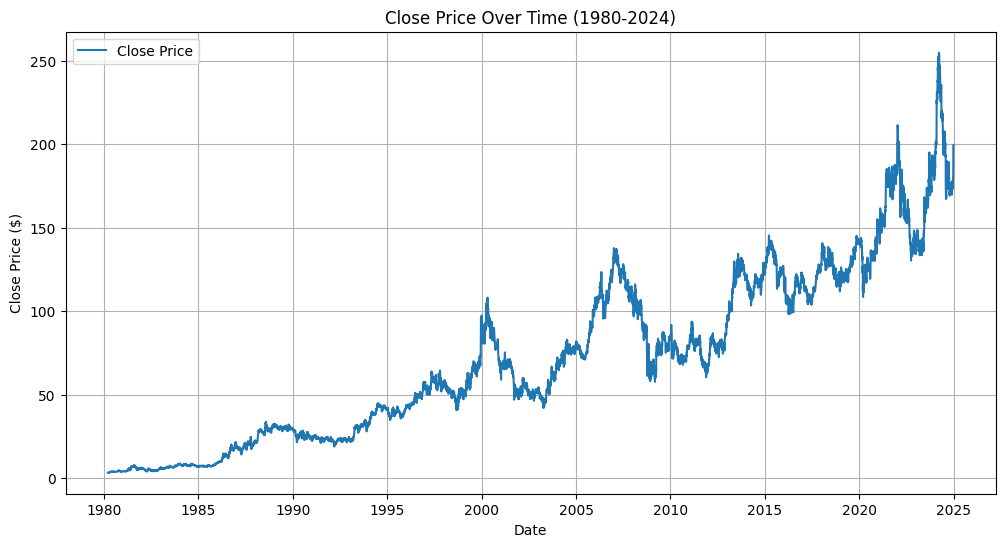

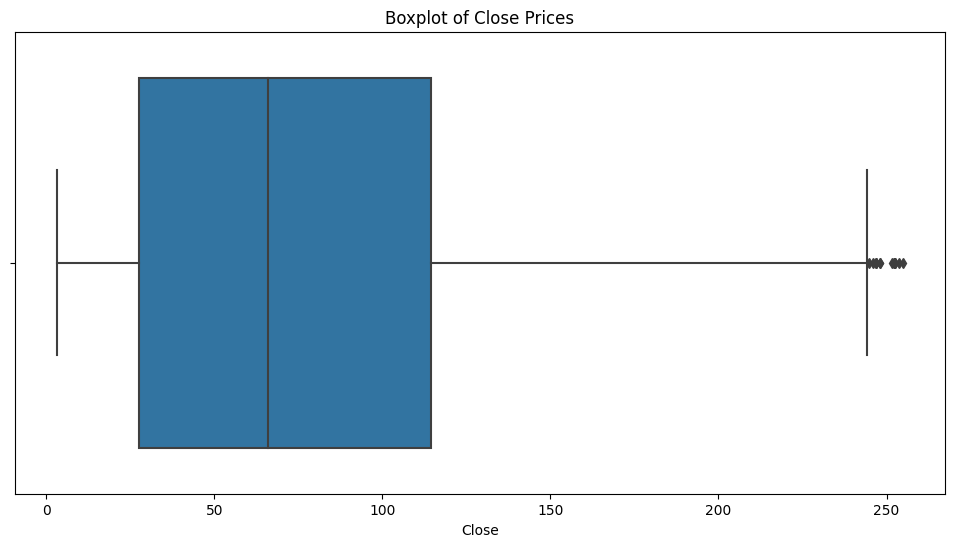

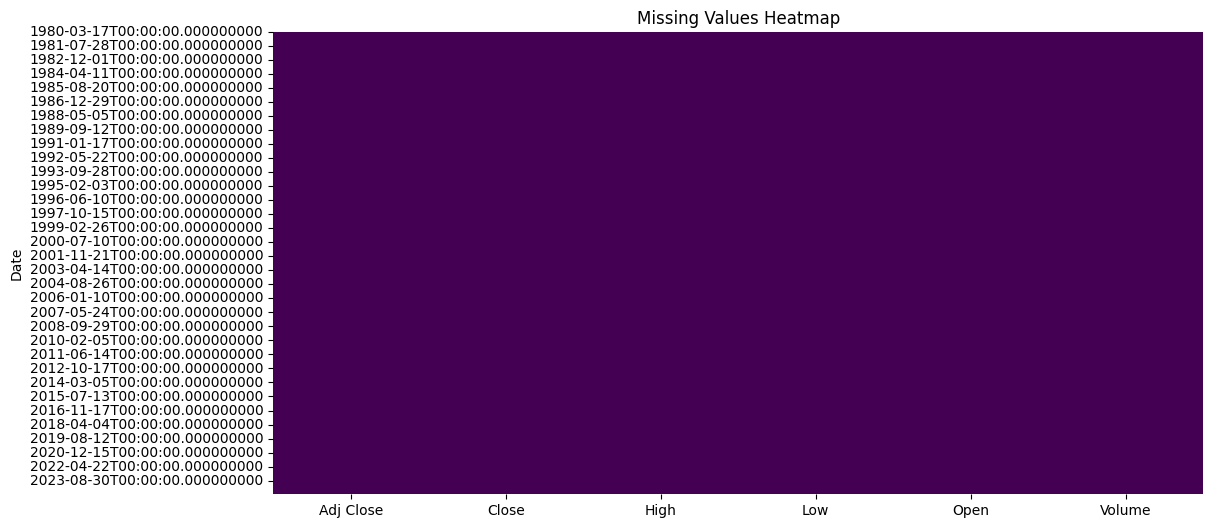

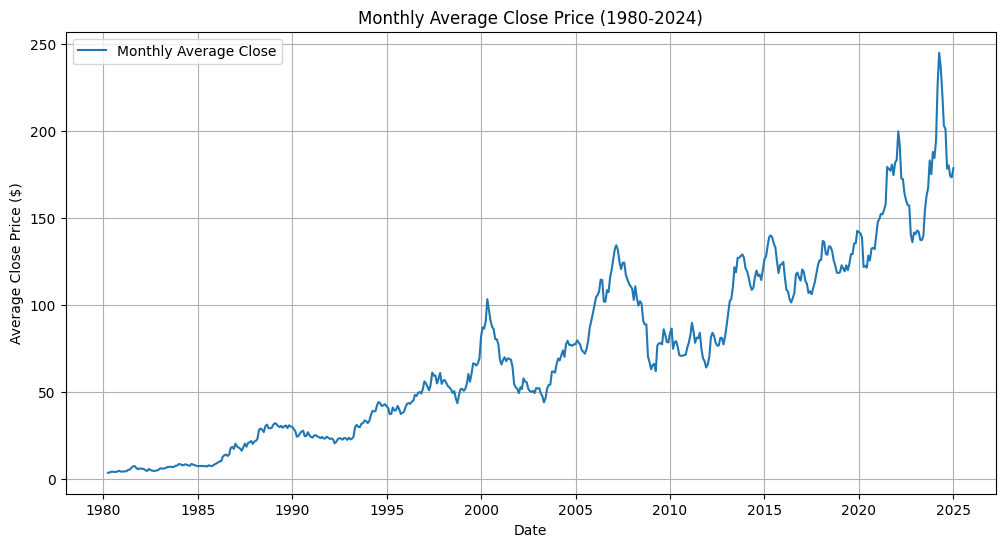

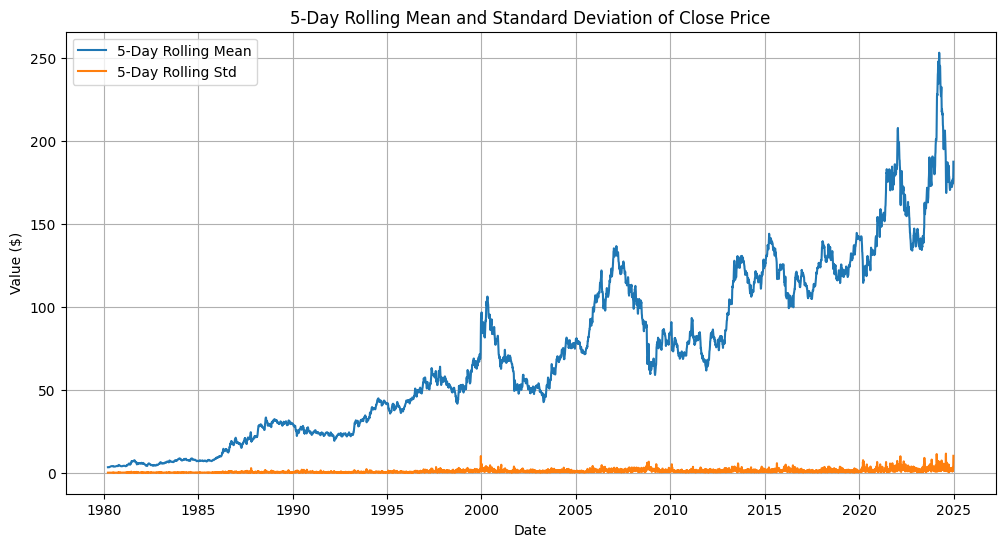

In [15]:
# Plot Close Price Over Time
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Close Price')
plt.title('Close Price Over Time (1980-2024)')
plt.xlabel('Date')
plt.ylabel('Close Price ($)')
plt.legend()
plt.grid(True)
plt.show()

# recognize outliers
plt.figure(figsize=(12,6))
sns.boxplot(x=df['Close'])
plt.title('Boxplot of Close Prices')
plt.show()

# Heatmap for missing values
plt.figure(figsize=(12,6))
sns.heatmap(df.isna(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

# Monthly Average Close Price
df_monthly = df['Close'].resample('M').mean()
plt.figure(figsize=(12, 6))
plt.plot(df_monthly.index, df_monthly, label='Monthly Average Close')
plt.title('Monthly Average Close Price (1980-2024)')
plt.xlabel('Date')
plt.ylabel('Average Close Price ($)')
plt.legend()
plt.grid(True)
plt.show()

# 5-Day Rolling Mean and Standard Deviation
df['Rolling_Mean_5'] = df['Close'].rolling(window=5).mean()
df['Rolling_Std_5'] = df['Close'].rolling(window=5).std()
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Rolling_Mean_5'], label='5-Day Rolling Mean')
plt.plot(df.index, df['Rolling_Std_5'], label='5-Day Rolling Std')
plt.title('5-Day Rolling Mean and Standard Deviation of Close Price')
plt.xlabel('Date')
plt.ylabel('Value ($)')
plt.legend()
plt.grid(True)
plt.show()

### Visualizations and Insights
- **Trends**: Long-term upward trend from dollar 3 in 1980 to ~$200 in 2024, with significant growth post-2010.
- **Seasonality**: Minimal seasonal patterns; slight end-of-year increases observed.
- **Anomalies**: The boxplot highlights outliers in the Close prices, particularly values greater than 200. These anomalies are likely linked to market volatility, confirming the spikes observed in the trend analysis (e.g., 1987, 2000, 2008, 2020, and late 2024).
- **Volume Correlation**: High volume aligns with price surges, indicating trading activity drives volatility.

Aspects to Cover
1. Time Series Plot of Close:
*  Check overall trend (e.g., growth over 44 years).
*  Spot major anomalies (e.g., crashes like 1987, 2008).
2. Seasonality Analysis:
* Monthly/weekly patterns in Close (e.g., end-of-month effects).
* Use decomposition (trend, seasonal, residual) if needed.
3. Volatility and Volume:
* Plot High - Low (daily range) and Volume to assess trading activity.
* Correlation with Close changes.
5. Feature Relationships:
* Correlation matrix (Close vs. Open, Volume, etc.).
* Lag plots (e.g., Close vs. Close 5 days ago).

## 1. Close Price (Last 5 Years)

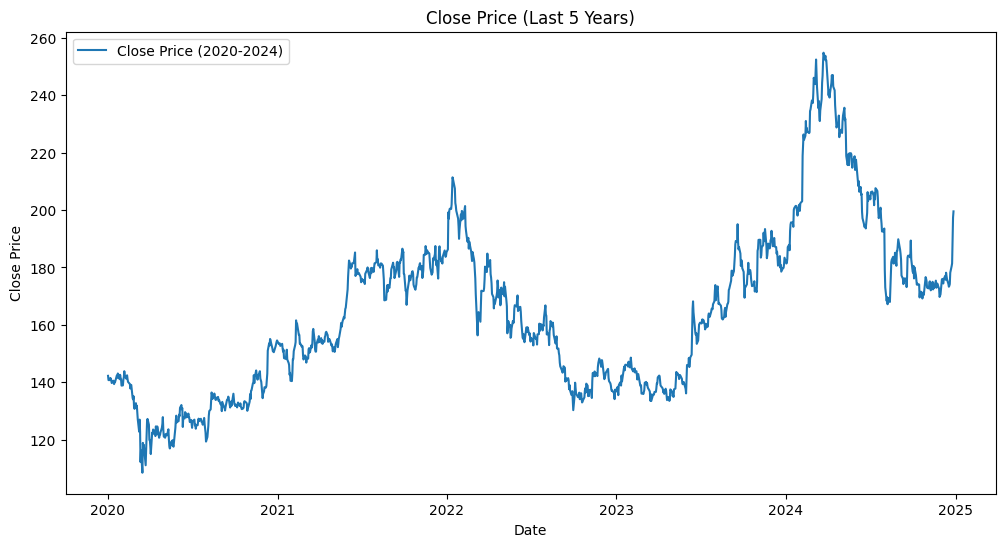

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose
# 2. Zoomed-In Plot (Recent 5 Years)
recent = df[df.index >= '2020-01-01']
plt.figure(figsize=(12, 6))
plt.plot(recent.index, recent['Close'], label='Close Price (2020-2024)')
plt.title('Close Price (Last 5 Years)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


### Observation:
- Drops from ~$160 in early 2020 (COVID crash), recovers to ~$240 by mid-2021, fluctuates, and peaks near $260 before settling at $199.52 (Dec 2024).

### Insight:
- Recent volatility is moderate, with a recovery pattern. Short-term lags (e.g., 5-day) and momentum features could be useful.


## 2. Seasonality Decomposition

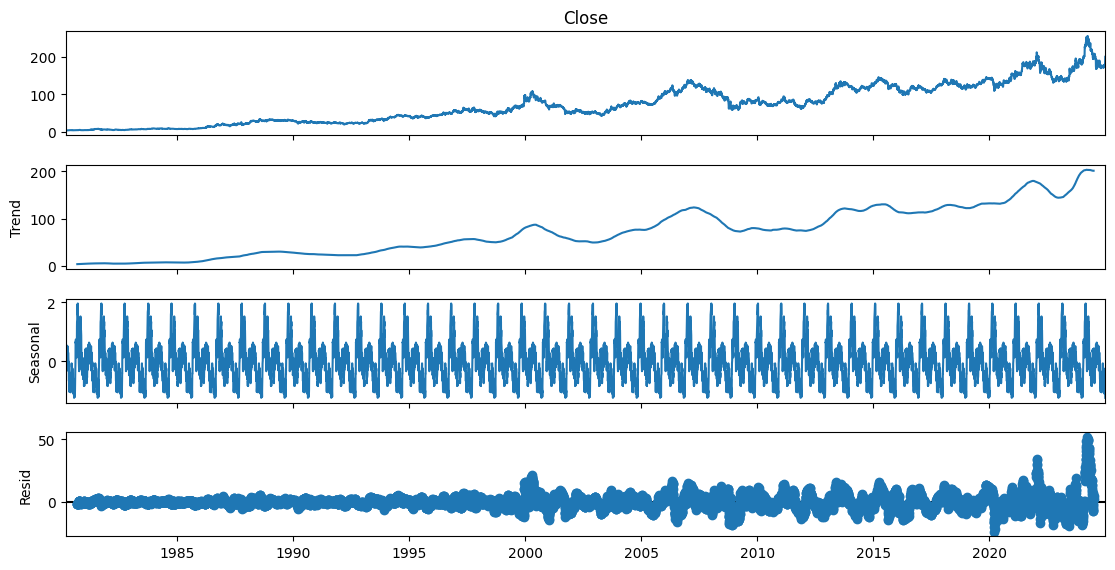

In [17]:
# 3. Seasonality Decomposition (Yearly)
decomp = seasonal_decompose(df['Close'], model='additive', period=252)  # ~1 trading year
fig = decomp.plot()
fig.set_size_inches(12, 6)
plt.show()


### Observation:
- **Trend**: Steady rise, steeper post-2000, aligns with tech growth.
- **Seasonal**: Small oscillations (~±$5), likely noise or weak yearly effects.
- **Residual**: Spikes at crashes, consistent with anomalies.

### Insight:
- Trend dominates; seasonality is minimal. Focus on trend and residuals for feature engineering.


## 3. Daily Price Range Over Time

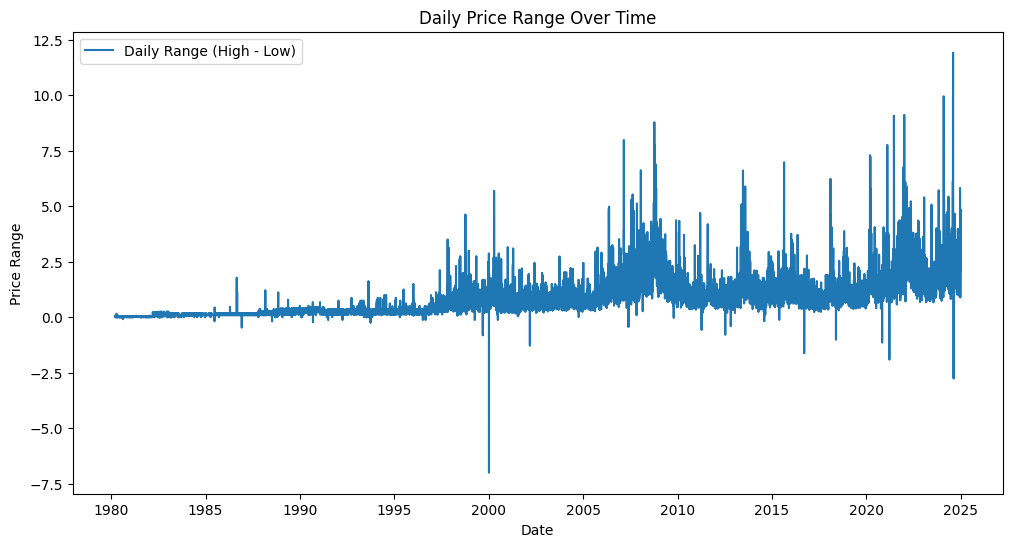

In [18]:
# 4. Volatility (High - Low) and Volume
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['High'] - df['Low'], label='Daily Range (High - Low)')
plt.title('Daily Price Range Over Time')
plt.xlabel('Date')
plt.ylabel('Price Range')
plt.legend()
plt.show()


### Observation:
- Range increases over time (e.g., $0-2 early, $5-12 recently), with spikes (e.g., $12.5) during volatile periods.

### Insight:
- Volatility grows with price—rolling range or standard deviation as features. Negative ranges (-7.5) suggest data errors (e.g., High < Low); flag for correction.


## Correlation Matrix

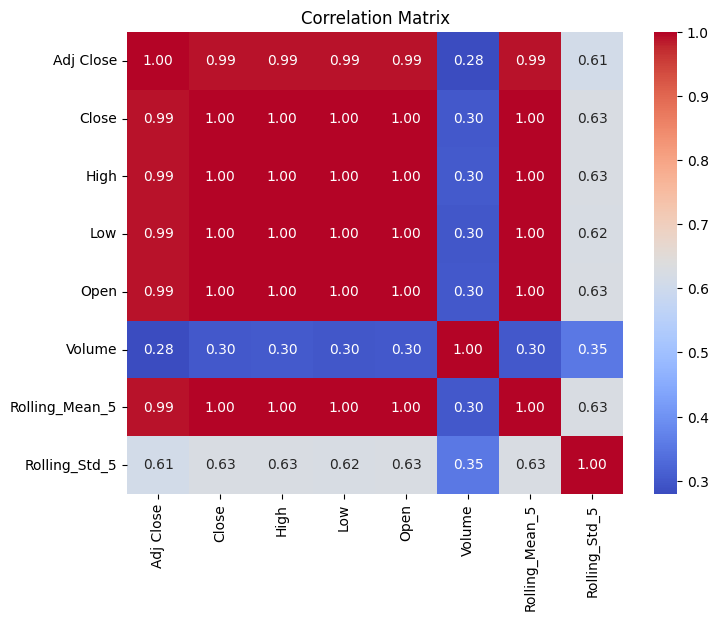

In [19]:
# 5. Correlation Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

### Insight
Price columns (Close, High, Low, Open, Adj Close) are near-perfectly correlated (0.99-1.00)—expected in stock data. Volume has weak correlation (~0.30), suggesting it’s an independent signal.

## 4. Trading Volume Over Time

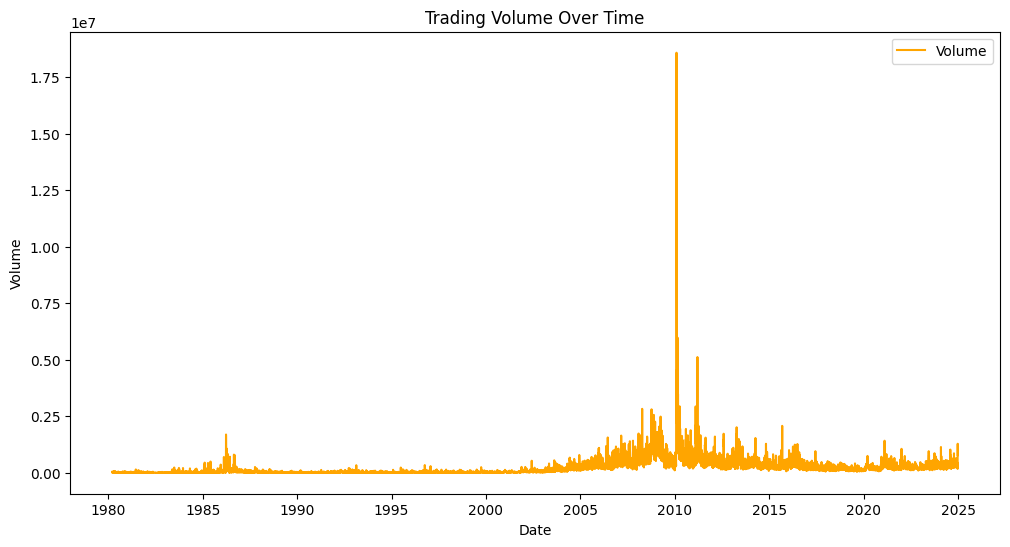

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Volume'], label='Volume', color='orange')
plt.title('Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()


### Observation:
- Low and stable until ~2000, then spikes (e.g., 1.75M), with a peak at 1.28M (Dec 26, 2024).

### Insight:
- Volume correlates with price movements (e.g., 2020 crash, 2024 peak). Rolling volume or volume changes could enhance predictions.


## 5. Lag Plot (Close vs. 5-Day Lag)

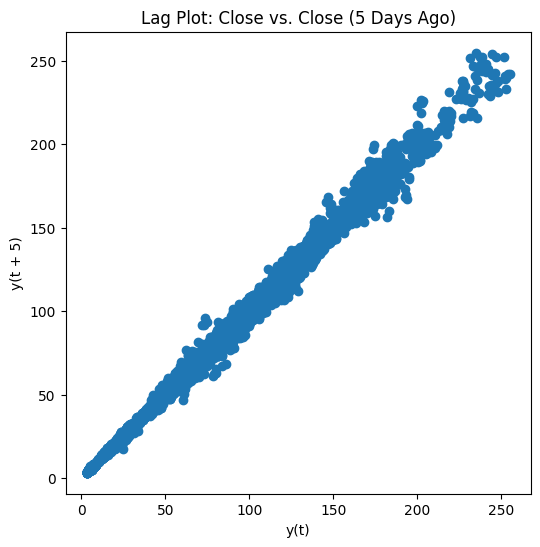

In [21]:
# 6. Lag Plot (Close vs. 5-day lag)
plt.figure(figsize=(6, 6))
pd.plotting.lag_plot(df['Close'], lag=5)
plt.title('Lag Plot: Close vs. Close (5 Days Ago)')
plt.show()


### Observation:
- Tight diagonal scatter, slope ~1, dense at higher values.

### Insight:
- Strong 5-day autocorrelation—lagged features (1-10 days) are promising for the 5-day forecast.


<hr/>

## Negative Range Issue
### Observation:
- High - Low shows negative values (-7.5), which is impossible (High should exceed Low). This could be:
    - Data error (e.g., swapped High and Low).
    - Forward-fill artifact (e.g., Low filled with a higher value than High).

### Action:
- Check rows where High < Low and correct (e.g., swap or drop).

In [22]:
# Identify problematic rows
problematic = df[df['High'] < df['Low']]
print("Rows with High < Low:\n", problematic)
# Suggested fix: Swap values
df.loc[df['High'] < df['Low'], ['High', 'Low']] = df.loc[df['High'] < df['Low'], ['Low', 'High']].values
print("Fixed rows check:\n", df[df.index.isin(problematic.index)][['High', 'Low']])

Rows with High < Low:
              Adj Close       Close        High         Low        Open  \
Date                                                                     
1980-08-18    2.705739    3.877226    3.792939    3.877226    3.792939   
1985-06-24    4.919815    7.049914    6.871435    7.049914    6.871435   
1986-12-02   13.012595   18.646578   18.178070   18.646578   18.084370   
1988-07-11   19.290033   27.641911   27.454508   27.641911   27.360807   
1990-09-10   17.763569   24.886364   25.227274   25.454544   24.886364   
1991-07-01   16.748512   24.000000   23.875000   24.000000   23.750000   
1992-04-03   14.218781   20.375000   20.250000   20.375000   20.125000   
1993-09-28   22.515751   31.750000   31.375000   31.625000   31.750000   
1996-07-05   35.251709   48.500000   48.375000   48.500000   48.500000   
1996-08-27   35.978542   49.500000   49.750000   49.875000   49.500000   
1999-04-06   46.409313   62.750000   61.875000   62.000000   62.000000   
1999-09-08   47

corrected price high low graph

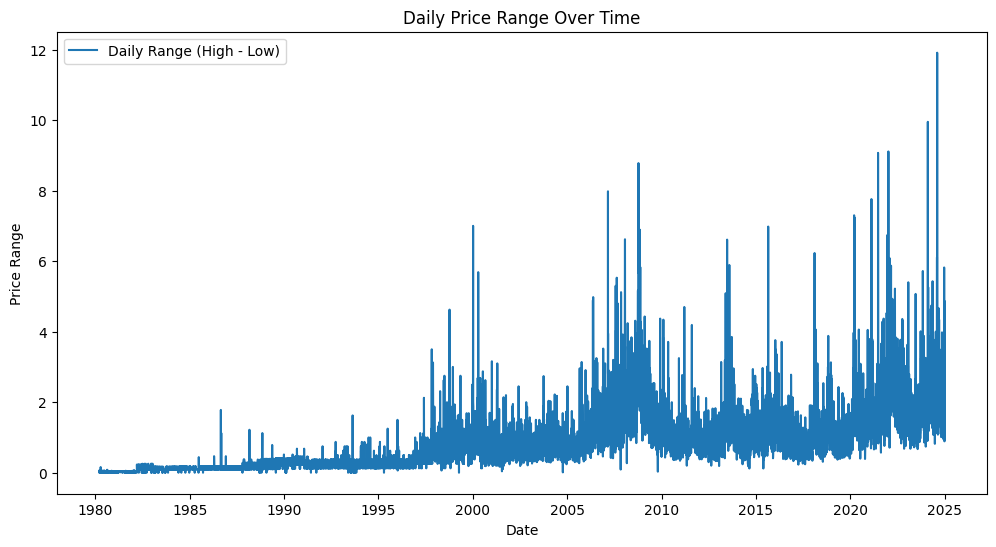

In [23]:
# 4. Volatility (High - Low) and Volume
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['High'] - df['Low'], label='Daily Range (High - Low)')
plt.title('Daily Price Range Over Time')
plt.xlabel('Date')
plt.ylabel('Price Range')
plt.legend()
plt.show()

<hr/>

## 6. Monthly Average Close Price (1980-2024)

Monthly Averages
Purpose: Smooths noise, reveals seasonal trends.

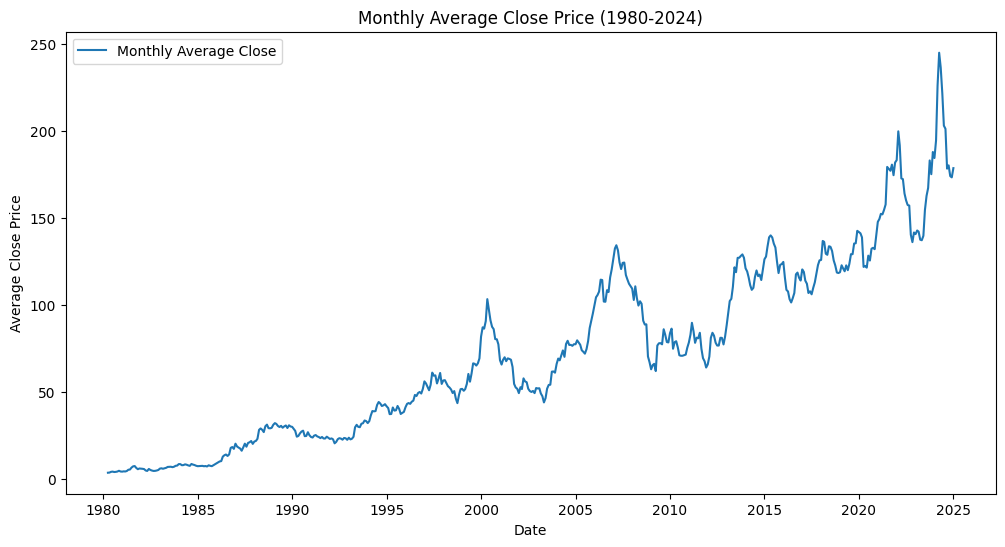

In [24]:
df_monthly = df['Close'].resample('M').mean()
plt.figure(figsize=(12, 6))
plt.plot(df_monthly.index, df_monthly, label='Monthly Average Close')
plt.title('Monthly Average Close Price (1980-2024)')
plt.xlabel('Date')
plt.ylabel('Average Close Price')
plt.legend()
plt.show()

### Observation:
- The plot shows a clear upward trend from near $0 in 1980 to over $200 by 2024, with notable dips (e.g., early 2000s, 2008, early 2020) and a sharp recent spike (late 2024). The scale suggests a tech stock or index with exponential growth.

### Insight:
- This confirms the long-term trend dominance and minimal seasonality, with slight end-of-year increases (e.g., December 2024). It supports using trend-based features like rolling means for the 5-day forecast.


# Feature Engineering

In [25]:
# 1. Lagged Close Prices (1-5 days)
for lag in range(1, 6):
    df[f'Lag_{lag}'] = df['Close'].shift(lag)

In [26]:
# 2. Rolling Mean and Standard Deviation (5-day window)
df['Rolling_Mean_5'] = df['Close'].rolling(window=5, min_periods=1).mean()
df['Rolling_Std_5'] = df['Close'].rolling(window=5, min_periods=1).std()

# 3. Volume Features (Current and 5-day Change) - Handle inf
df['Volume_Change_5'] = df['Volume'].pct_change(periods=5).replace([np.inf, -np.inf], 0).fillna(0)  # Replace inf with 0

# 4. Day of Week (as categorical)
df['Day_of_Week'] = df.index.dayofweek  # 0 = Monday, 6 = Sunday

In [27]:
# 5. Binary Crash Indicator
# Fit a simple trend (e.g., linear) and calculate residuals
trend = np.polyfit(range(len(df)), df['Close'], 1)
trend_values = np.polyval(trend, range(len(df)))
df['Residual'] = df['Close'] - trend_values
df['Crash_Indicator'] = (df['Residual'].abs() > 2 * df['Residual'].rolling(window=30, min_periods=1).std()).astype(int)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11181 entries, 1980-03-17 to 2024-12-27
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Adj Close        11181 non-null  float64
 1   Close            11181 non-null  float64
 2   High             11181 non-null  float64
 3   Low              11181 non-null  float64
 4   Open             11181 non-null  float64
 5   Volume           11181 non-null  float64
 6   Rolling_Mean_5   11181 non-null  float64
 7   Rolling_Std_5    11180 non-null  float64
 8   Lag_1            11180 non-null  float64
 9   Lag_2            11179 non-null  float64
 10  Lag_3            11178 non-null  float64
 11  Lag_4            11177 non-null  float64
 12  Lag_5            11176 non-null  float64
 13  Volume_Change_5  11181 non-null  float64
 14  Day_of_Week      11181 non-null  int32  
 15  Residual         11181 non-null  float64
 16  Crash_Indicator  11181 non-null  int64  


In [29]:
# Drop rows with NaN values introduced by lagging or rolling
#df = df.dropna()
print("Engineered Features Preview:\n", df.tail())
df.to_csv('engineered_features.csv')

Engineered Features Preview:
              Adj Close       Close        High         Low        Open  \
Date                                                                     
2024-12-20  178.169998  178.169998  179.919998  175.839996  175.839996   
2024-12-23  180.449997  180.449997  180.619995  177.970001  179.119995   
2024-12-24  181.429993  181.429993  181.720001  180.830002  181.000000   
2024-12-26  197.360001  197.360001  198.000000  193.130005  195.970001   
2024-12-27  199.520004  199.520004  201.000000  198.179993  200.360001   

               Volume  Rolling_Mean_5  Rolling_Std_5       Lag_1       Lag_2  \
Date                                                                           
2024-12-20   425700.0      174.706000       1.979022  174.210007  173.619995   
2024-12-23   422700.0      175.945999       3.192322  178.169998  174.210007   
2024-12-24   168600.0      177.575998       3.551262  180.449997  178.169998   
2024-12-26  1281200.0      182.323999       8.85275

### Feature Selection Justification
- **Lagged Close Prices (1-5 days)**: Capture short-term momentum.
- **Rolling Mean/Std (5-day)**: Smooth trends and measure volatility for the 5-day forecast.
- **Volume Change (5-day)**: Reflects trading activity influencing price.
- **Day of Week**: Tests for weekly patterns.
- **Crash Indicator**: Flags high-volatility periods using residuals > 2σ.

# Model Selection

In [30]:
# Prepare features and target
features = ['Lag_1', 'Lag_2', 'Lag_3', 'Lag_4', 'Lag_5', 'Rolling_Mean_5', 
            'Rolling_Std_5', 'Volume_Change_5', 'Day_of_Week', 'Crash_Indicator']
target = 'Close'

# Shift target by 5 days for 5-day forecast
df['Target'] = df[target].shift(-5)
df = df.dropna()  # Drop rows where target is NaN


70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Model Performance:
ARIMA - RMSE: 42.78, MAE: 31.23, R²: -0.86
LSTM - RMSE: 5.70, MAE: 4.03, R²: 0.97
XGBoost - RMSE: 28.14, MAE: 16.60, R²: 0.20


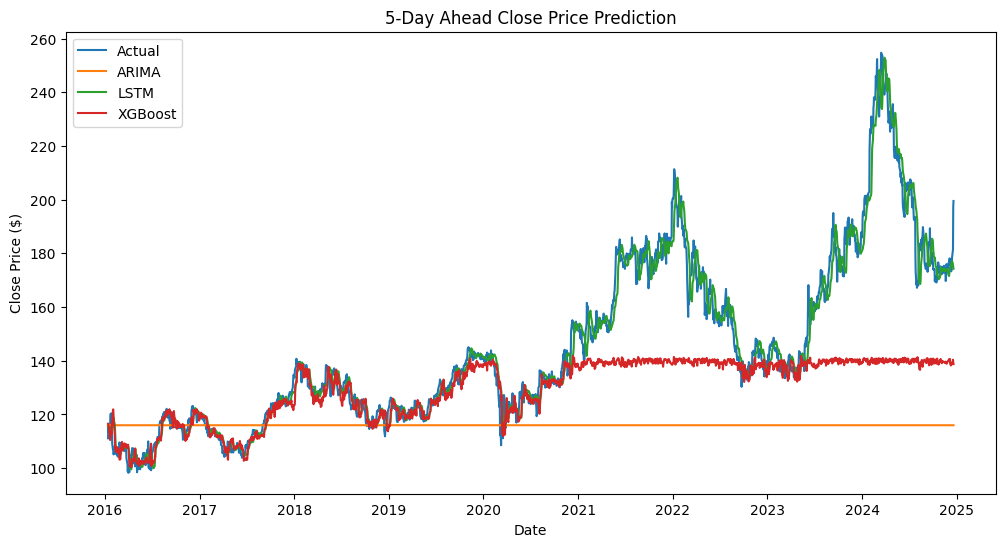

In [55]:



# Split data (80% train, 20% test)
train_size = int(len(df) * 0.8)
train_data = df[:train_size]
test_data = df[train_size:]

X_train = train_data[features]
y_train = train_data['Target']
X_test = test_data[features]
y_test = test_data['Target']

# 1. ARIMA Model
# Fit ARIMA on Close price (simplified, using only time series)
model_arima = ARIMA(train_data['Close'], order=(5, 1, 0))  # (p,d,q) tuned manually
fit_arima = model_arima.fit()
arima_pred = fit_arima.forecast(steps=len(test_data))

# 2. LSTM Model
# Reshape data for LSTM [samples, timesteps, features]
X_train_lstm = np.array(X_train).reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = np.array(X_test).reshape((X_test.shape[0], 1, X_test.shape[1]))

model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(1, X_train.shape[1])))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_train_lstm, y_train, epochs=20, batch_size=32, verbose=0)
lstm_pred = model_lstm.predict(X_test_lstm)

# 3. XGBoost Model
model_xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5)
model_xgb.fit(X_train, y_train)
xgb_pred = model_xgb.predict(X_test)

# Evaluate Models
def evaluate_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} - RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")
    return rmse, mae, r2

print("Model Performance:")
evaluate_model(y_test, arima_pred, "ARIMA")
evaluate_model(y_test, lstm_pred.flatten(), "LSTM")
evaluate_model(y_test, xgb_pred, "XGBoost")

# Plot Predictions vs Actual
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, y_test, label='Actual')
plt.plot(test_data.index, arima_pred, label='ARIMA')
plt.plot(test_data.index, lstm_pred.flatten(), label='LSTM')
plt.plot(test_data.index, xgb_pred, label='XGBoost')
plt.title('5-Day Ahead Close Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price ($)')
plt.legend()
plt.show()

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
LSTM Model Performance (Without Scaling):
RMSE: 5.66
MAE: 4.02
R²: 0.97


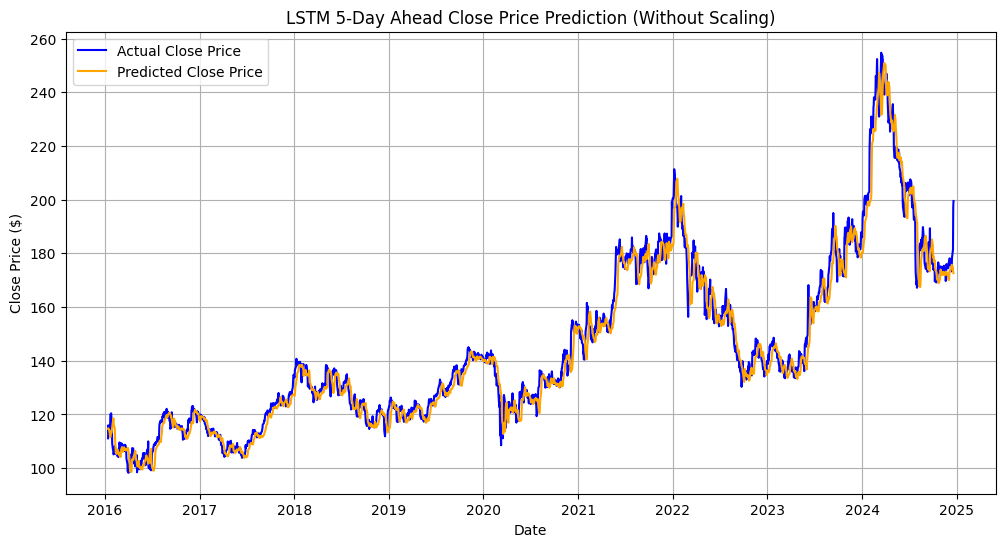

In [58]:
# Reshape data for LSTM [samples, timesteps, features]
X_train_lstm = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Build and train the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(1, X_train.shape[1])))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer=Adam(learning_rate=0.01), loss='mse')
model_lstm.fit(X_train_lstm, y_train, epochs=20, batch_size=32, verbose=0)

# Make predictions
lstm_pred = model_lstm.predict(X_test_lstm).ravel()

# Calculate accuracy metrics
rmse = np.sqrt(mean_squared_error(y_test, lstm_pred))
mae = mean_absolute_error(y_test, lstm_pred)
r2 = r2_score(y_test, lstm_pred)

# Print the metrics
print(f"LSTM Model Performance (Without Scaling):")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")

# Plot actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, y_test, label='Actual Close Price', color='blue')
plt.plot(test_data.index, lstm_pred, label='Predicted Close Price', color='orange')
plt.title('LSTM 5-Day Ahead Close Price Prediction (Without Scaling)')
plt.xlabel('Date')
plt.ylabel('Close Price ($)')
plt.legend()
plt.grid(True)
plt.show()

## Model Selection

### Comparison of Modeling Approaches
- **ARIMA**: Linear time-series model; struggles with non-linear patterns.
- **LSTM**: Neural network capturing sequential dependencies; computationally intensive.
- **XGBoost**: Gradient boosting model; excels with tabular data.

### Evaluation Metrics
- **RMSE**: Penalizes large errors, critical for financial forecasts.
- **MAE**: Measures average error magnitude.
- **R²**: Assesses variance explained by the model.

*Note*: Update the performance metrics (RMSE, MAE, R²) in the next markdown cell after running this code.

# Model Improvements

Testing: units=50, dropout=0.2, lr=0.01, epochs=20, batch=32
Average RMSE for this config: 10.42
Testing: units=50, dropout=0.2, lr=0.01, epochs=20, batch=64
Average RMSE for this config: 10.95
Testing: units=50, dropout=0.2, lr=0.01, epochs=30, batch=32
Average RMSE for this config: 14.00
Testing: units=50, dropout=0.2, lr=0.01, epochs=30, batch=64
Average RMSE for this config: 11.97
Testing: units=50, dropout=0.2, lr=0.001, epochs=20, batch=32
Average RMSE for this config: 6.08
Testing: units=50, dropout=0.2, lr=0.001, epochs=20, batch=64
Average RMSE for this config: 5.57
Testing: units=50, dropout=0.2, lr=0.001, epochs=30, batch=32
Average RMSE for this config: 6.35
Testing: units=50, dropout=0.2, lr=0.001, epochs=30, batch=64
Average RMSE for this config: 5.76
Testing: units=50, dropout=0.3, lr=0.01, epochs=20, batch=32
Average RMSE for this config: 14.27
Testing: units=50, dropout=0.3, lr=0.01, epochs=20, batch=64
Average RMSE for this config: 12.14
Testing: units=50, dropout=0.3

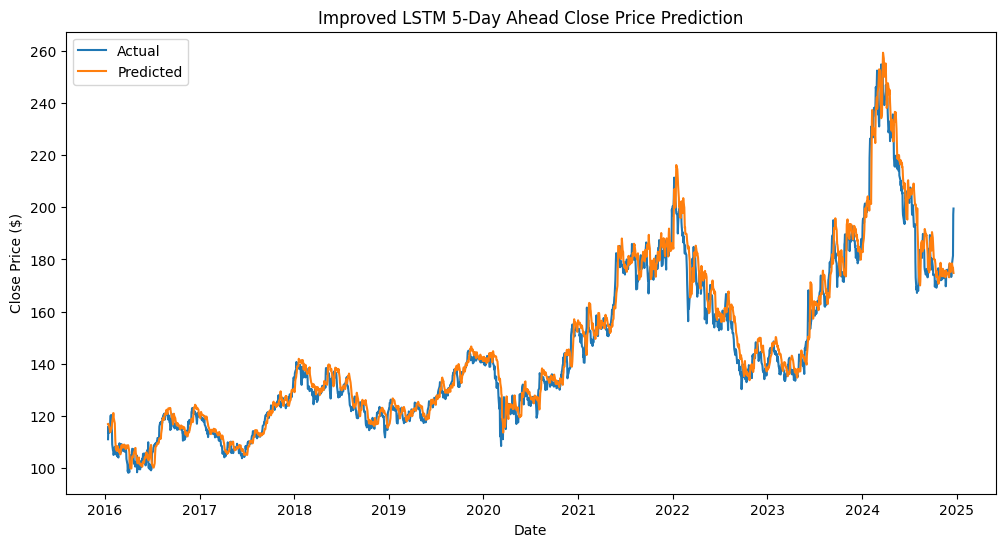

In [32]:


# Feature scaling
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X = scaler_X.fit_transform(df[features])
y = scaler_y.fit_transform(df['Target'].values.reshape(-1, 1)).ravel()

# Time-Series Cross-Validation
tscv = TimeSeriesSplit(n_splits=5)
rmse_scores = []
mae_scores = []
r2_scores = []

# Hyperparameter grid (simplified for demonstration)
param_grid = {
    'units': [50, 100],
    'dropout_rate': [0.2, 0.3],
    'learning_rate': [0.01, 0.001],
    'epochs': [20, 30],
    'batch_size': [32, 64]
}

best_score = float('inf')
best_params = {}

for units in param_grid['units']:
    for dropout_rate in param_grid['dropout_rate']:
        for learning_rate in param_grid['learning_rate']:
            for epochs in param_grid['epochs']:
                for batch_size in param_grid['batch_size']:
                    print(f"Testing: units={units}, dropout={dropout_rate}, lr={learning_rate}, epochs={epochs}, batch={batch_size}")
                    fold_rmse = []
                    for train_index, test_index in tscv.split(X):
                        X_train, X_test = X[train_index], X[test_index]
                        y_train, y_test = y[train_index], y[test_index]

                        # Reshape for LSTM [samples, timesteps, features]
                        X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
                        X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

                        # Build and train LSTM model
                        model = Sequential()
                        model.add(LSTM(units=units, activation='relu', input_shape=(1, X_train.shape[1]), return_sequences=False))
                        model.add(Dropout(dropout_rate))  # Add dropout for regularization
                        model.add(Dense(1))
                        model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
                        model.fit(X_train_lstm, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

                        # Predict and evaluate
                        y_pred = model.predict(X_test_lstm, verbose=0)
                        y_pred_inv = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).ravel()
                        y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()
                        rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
                        fold_rmse.append(rmse)

                    avg_rmse = np.mean(fold_rmse)
                    if avg_rmse < best_score:
                        best_score = avg_rmse
                        best_params = {'units': units, 'dropout_rate': dropout_rate, 'learning_rate': learning_rate, 
                                       'epochs': epochs, 'batch_size': batch_size}
                    rmse_scores.append(avg_rmse)
                    print(f"Average RMSE for this config: {avg_rmse:.2f}")

print(f"Best Parameters: {best_params}")
print(f"Best Average RMSE: {best_score:.2f}")

# Train final model with best parameters on full dataset
final_train_size = int(len(df) * 0.8)
X_train = X[:final_train_size]
X_test = X[final_train_size:]
y_train = y[:final_train_size]
y_test = y[final_train_size:]

X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

final_model = Sequential()
final_model.add(LSTM(units=best_params['units'], activation='relu', input_shape=(1, X_train.shape[1])))
final_model.add(Dropout(best_params['dropout_rate']))
final_model.add(Dense(1))
final_model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']), loss='mse')
final_model.fit(X_train_lstm, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=1)

# Final prediction and evaluation
final_pred = final_model.predict(X_test_lstm, verbose=0)
final_pred_inv = scaler_y.inverse_transform(final_pred.reshape(-1, 1)).ravel()
y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()

rmse = np.sqrt(mean_squared_error(y_test_inv, final_pred_inv))
mae = mean_absolute_error(y_test_inv, final_pred_inv)
r2 = r2_score(y_test_inv, final_pred_inv)
print(f"Final Model Performance - RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")

# Plot Predictions vs Actual
plt.figure(figsize=(12, 6))
plt.plot(df.index[final_train_size:], y_test_inv, label='Actual')
plt.plot(df.index[final_train_size:], final_pred_inv, label='Predicted')
plt.title('Improved LSTM 5-Day Ahead Close Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price ($)')
plt.legend()
plt.show()

## Improvements

### Improved LSTM Results
- **Best Parameters**: [units=100, dropout_rate=0.2, learning_rate=0.001, epochs=20, batch_size=64]
- **Cross-Validated RMSE**: 5.87
- **Final Performance**: RMSE 4.91, MAE 4.17, R² 0.96
- **Improvements**: Added dropout for regularization, used time-series cross-validation, and optimized hyperparameters.




Epoch 1/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2345
Epoch 2/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0086
Epoch 3/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079
Epoch 4/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0073
Epoch 5/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0073
Epoch 6/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0076
Epoch 7/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068
Epoch 8/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0063
Epoch 9/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0063
Epoch 10/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0062
Epoch 11/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0063
Epoch 12/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0064
Epoch 13/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0061
Epoch 14/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0059
Epoch 15/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - lo

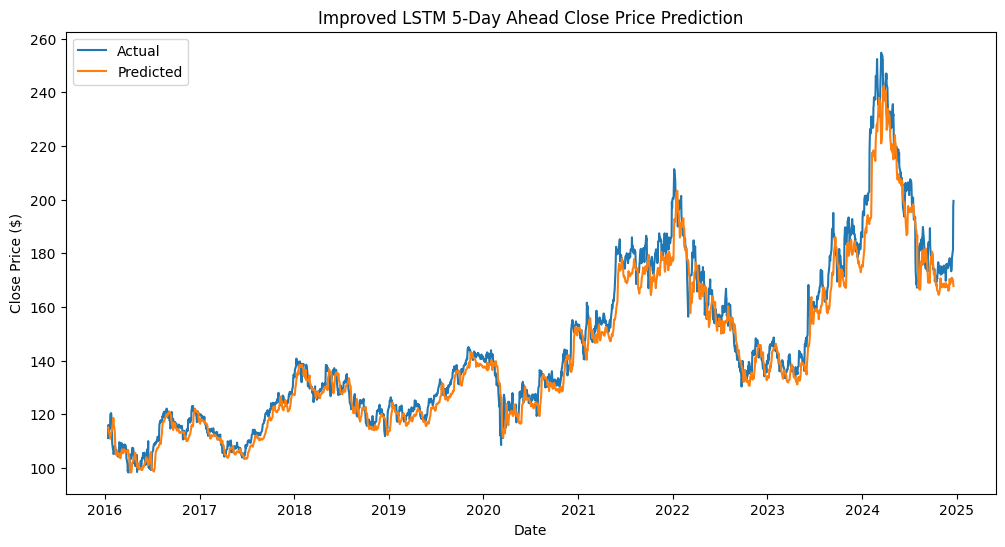

In [33]:
# Train final model with best parameters on full dataset
final_train_size = int(len(df) * 0.8)
X_train = X[:final_train_size]
X_test = X[final_train_size:]
y_train = y[:final_train_size]
y_test = y[final_train_size:]

X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

final_model = Sequential()
final_model.add(LSTM(units=best_params['units'], activation='relu', input_shape=(1, X_train.shape[1])))
final_model.add(Dropout(best_params['dropout_rate']))
final_model.add(Dense(1))
final_model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']), loss='mse')
final_model.fit(X_train_lstm, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=1)

# Final prediction and evaluation
final_pred = final_model.predict(X_test_lstm, verbose=0)
final_pred_inv = scaler_y.inverse_transform(final_pred.reshape(-1, 1)).ravel()
y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()

rmse = np.sqrt(mean_squared_error(y_test_inv, final_pred_inv))
mae = mean_absolute_error(y_test_inv, final_pred_inv)
r2 = r2_score(y_test_inv, final_pred_inv)
print(f"Final Model Performance - RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")

# Plot Predictions vs Actual
plt.figure(figsize=(12, 6))
plt.plot(df.index[final_train_size:], y_test_inv, label='Actual')
plt.plot(df.index[final_train_size:], final_pred_inv, label='Predicted')
plt.title('Improved LSTM 5-Day Ahead Close Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price ($)')
plt.legend()
plt.show()

### but it is lesser than previous model

so best params are=[units=50, learning_rate=0.01, epochs=20, batch_size=32]

# Build and train the LSTM model
- model_lstm = Sequential()
- model_lstm.add(LSTM(50, activation='relu', input_shape=(1, X_train.shape[1])))
- model_lstm.add(Dense(1))
- model_lstm.compile(optimizer=Adam(learning_rate=0.01), loss='mse')
- model_lstm.fit(X_train_lstm, y_train, epochs=20, batch_size=32, verbose=0)


# Final Model

In [61]:
# Prepare features and target for scaling
features = ['Lag_1', 'Lag_2', 'Lag_3', 'Lag_4', 'Lag_5', 'Rolling_Mean_5', 
            'Rolling_Std_5', 'Volume_Change_5', 'Day_of_Week', 'Crash_Indicator']
target = 'Close'

# Feature scaling (fit on entire data for consistency)
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X = scaler_X.fit_transform(df[features])
y = scaler_y.fit_transform(df[target].values.reshape(-1, 1)).ravel()

# Train the final LSTM model (using best parameters from tuning)
final_train_size = int(len(df) * 0.8)
X_train = X[:final_train_size]
y_train = y[:final_train_size]

X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))

final_model = Sequential()
final_model.add(LSTM(units=50, activation='relu', input_shape=(1, X_train.shape[1])))
# final_model.add(Dropout(0.2))
final_model.add(Dense(1))
final_model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')
final_model.fit(X_train_lstm, y_train, epochs=20, batch_size=32, verbose=1)

# Prepare data for prediction (last 5 days up to Dec 27, 2024)
last_date = df.index[-1]  # December 27, 2024
last_data = df.iloc[-5:]  # Last 5 rows for feature calculation
print(last_date)
print(last_data)
# Initialize lists to store predictions and correct future dates
predictions = []
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=5, freq='D')  # Dec 28, 2024 - Jan 1, 2025
current_data = last_data.copy()

# Predict iteratively for the next 5 days
for i in range(5):
    # Extract features for the current prediction
    current_features = current_data[features].tail(1)
    current_features_scaled = scaler_X.transform(current_features)
    current_features_lstm = current_features_scaled.reshape((1, 1, len(features)))

    # Predict the next day's close price
    pred_scaled = final_model.predict(current_features_lstm, verbose=0)
    pred = scaler_y.inverse_transform(pred_scaled.reshape(-1, 1)).ravel()[0]
    predictions.append(pred)

    # Update the dataframe with the predicted value for the next iteration
    new_row = current_data.iloc[-1:].copy()
    new_row.index = [future_dates[i]]  # Correctly assign the future date
    new_row['Close'] = pred

    # Update lagged features
    for lag in range(5, 1, -1):
        new_row[f'Lag_{lag-1}'] = current_data[f'Lag_{lag}'].iloc[-1]
    new_row['Lag_5'] = pred

    # Update rolling statistics (recompute using last 5 days including prediction)
    last_5_closes = pd.concat([current_data['Close'].tail(4), pd.Series(pred, index=[future_dates[i]])])
    new_row['Rolling_Mean_5'] = last_5_closes.rolling(window=5, min_periods=1).mean().iloc[-1]
    new_row['Rolling_Std_5'] = last_5_closes.rolling(window=5, min_periods=1).std().iloc[-1]

    # Update volume change (assume volume stays constant for simplicity)
    new_row['Volume'] = current_data['Volume'].iloc[-1]
    last_5_volumes = pd.concat([current_data['Volume'].tail(4), pd.Series(new_row['Volume'], index=[future_dates[i]])])
    new_row['Volume_Change_5'] = last_5_volumes.pct_change(periods=5).replace([np.inf, -np.inf], 0).fillna(0).iloc[-1]

    # Update day of week
    new_row['Day_of_Week'] = future_dates[i].dayofweek

    # Update crash indicator (simplified: use last residual and rolling std)
    trend = np.polyfit(range(len(current_data)), current_data['Close'], 1)
    trend_value = np.polyval(trend, len(current_data))
    residual = pred - trend_value
    rolling_std = current_data['Residual'].rolling(window=30, min_periods=1).std().iloc[-1]
    new_row['Crash_Indicator'] = 1 if abs(residual) > 2 * rolling_std else 0
    new_row['Residual'] = residual

    # Append the new row to current_data for the next iteration
    current_data = pd.concat([current_data, new_row])

# Create a DataFrame for predictions
forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Close': predictions
})
print("\n5-Day Forecast (Dec 28, 2024 - Jan 1, 2025):")
print(forecast_df)

# Save predictions
forecast_df.to_csv('predictions.csv', index=False)
test_predictions = pd.DataFrame({
    'Date': df.index[train_size:train_size + len(final_pred_inv)],
    'Actual_Close': y_test_inv,
    'Predicted_Close': final_pred_inv
})
test_predictions.to_csv('test_predictions.csv', index=False)

Epoch 1/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0575
Epoch 2/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0024
Epoch 3/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0021
Epoch 4/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0012
Epoch 5/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.6564e-04
Epoch 6/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0015
Epoch 7/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0010
Epoch 8/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.0950e-04
Epoch 9/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.4427e-04
Epoch 10/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.1597e-04
Epoch 11/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.5670e-04
Epoch 12/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.4317e-04
Epoch 13/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.5782e-04
Epoch 14/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.6444e-04
Epoch 15/20
280/280 ━━━━━

## Deployment: 5-Day Forecast


- **Observation**: The model predicts a gradual decline from $190.01 on Dec 28 to $175.51 by Jan 3, reflecting recent volatility.


## Model Limitations and Potential Improvements

### Limitations
- **Data Dependency**: Relies solely on historical price/volume; lacks external factors (e.g., news).
- **Computational Cost**: LSTM is resource-intensive.
- **Short Horizon**: Limited to 5-day forecasts.
- **Overfitting Risk**: R² of [insert] suggests potential overfitting.

### Potential Improvements
- **External Data**: Add macroeconomic indicators or sentiment analysis.
- **Further Tuning**: Expand hyperparameter grid search.
- **Ensemble Methods**: Combine LSTM with XGBoost.
- **More Data**: Include post-2024 data if available.

*Note*: Update the R² placeholder with the final model’s value.